In [92]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import yaml

In [93]:
from catboost import CatBoostRegressor, CatBoostClassifier
from catboost import Pool
from sklearn.model_selection import  train_test_split
from sklearn.metrics import (
    f1_score,
    accuracy_score,
    precision_score,
    average_precision_score,
    recall_score,
    matthews_corrcoef,
    roc_auc_score,
    confusion_matrix,
    classification_report,
    r2_score,
    mean_squared_error,
    mean_absolute_error,
    mean_absolute_percentage_error,
)
import shap
from sklearn.model_selection import RepeatedKFold, RepeatedStratifiedKFold

In [94]:
def score_regression_simple(target, predictions,) -> pd.DataFrame:
    '''
    Функция для подсчета метрик
    '''
    predictions = np.array(predictions)

    metrics = {
        "R2":       round(r2_score(target, predictions),3),
        "MAE":  round(mean_absolute_error(target, predictions),3),
        "MSE":  round(mean_squared_error(target, predictions),3),
        "RMSE":   round((np.sqrt(mean_squared_error(target, predictions))),3),
        "MAPE":        round(mean_absolute_percentage_error(target, predictions),3),
        } 
    return metrics


def score_classifier_simple(target, predictions, threshold=0.5) -> pd.DataFrame:
    '''
    Функция для подсчета метрик
    '''
    predictions = np.array(predictions)
    response = (predictions > threshold).astype(int)

    metrics = {
        "roc_auc_score":   round((np.sqrt(roc_auc_score(target, predictions))),3),
        "av_precision_score": round((np.sqrt(average_precision_score(target, predictions))),3),
        "accuracy_score":  round(accuracy_score(target, response),3),
        "precision_score":  round(precision_score(target, response),3),
        "recall_score":   round((np.sqrt(recall_score(target, response))),3),
        "f1_score":       round(f1_score(target, response),3),
        "matthews_corrcoef":        round(matthews_corrcoef(target, response),3),
        } 
    return metrics

In [95]:
def calc_min_price_rolling(data, delta_h=24, features=None):
    if features is None:
        features = ['rarity', 'genesis', 'sneaker_type', 'level', 'mint']

    result = np.zeros(len(data))

    for i in range(len(data)):
        #i = 156
        sample = data.iloc[i]
        data_tmp = data.iloc[:i]
        data_tmp = data_tmp[data_tmp['date'] > (sample['date'] - pd.Timedelta(delta_h, unit='h'))]

        for feature in features:
            data_tmp = data_tmp[(data_tmp[feature] == sample[feature])]
        result[i] = data_tmp['price'].min()
    
    return result

# SETUP

In [96]:
CONFIG_DIR = '../app/'

In [97]:
with open(f"{CONFIG_DIR}config_prod.yml", 'r') as ymlfile:
    config = yaml.load(ymlfile, Loader=yaml.SafeLoader)

In [98]:
BD_NAME = f'{config["DATASET"]}.csv'
BD_FOLDER = './data'
VERSION = config["VERSION"]
START_DATE = '2022-09-03'
TETS_DATE = '2022-09-29'

In [99]:
data_quality_expected_range_dict = {
    'sneaker':
        {
        #'is_type': {'genesis': bool},
        'is_in':
            {
            'rarity': ['common', 'uncommon', 'rare'],
            'sneaker_type': ['ranger', 'sprinter', 'hiker', 'coacher'],
            },
        'min_max':
            {
            'level': [0, 30],
            'base_performance': [0, 40],
            'base_fortune': [0, 40],
            'base_joy': [0, 40],
            'base_durability': [0, 40],
            'performance': [0, 500],
            'fortune': [0, 300],
            'joy': [0, 300],
            'durability': [0, 300],
            'mint': [0, 7],
            'buy_count_12H': [0, 500],
            'buy_count_24H': [0, 1000],
            'sell_count_24H': [0, 2000],
            'cancel_count_24H': [0, 1000],
            'token_all_activity_3H': [0, 30],
            'token_sell_activity_6H': [0, 30],
            },
        }
}

# DATA

In [100]:
data = pd.read_csv(f'{BD_FOLDER}/{BD_NAME}')
data

Columns (62,63,64,65,66,67) have mixed types. Specify dtype option on import or set low_memory=False.


,timestamp,mrk_id,token_id,event,wallet_from,wallet_to,price,item_type,rarity,sneaker_type,...,mrk_floor__rarity_type_genesis,mrk_floor__rarity_type,mrk_floor__all,mkr_count__rarity_type_genesis_lvl_mint,mrk_count__rarity_type_genesis_lvl,mrk_count__rarity_type_genesis,mrk_count__rarity_type,mrk_count__sneaker_all,mrk_count__box_all,mrk_count__all
0,1665554362,65681,65004,sell,0x17d288f53083015bcdca3ecdf9396a577a0005de,NaN,0.25,sneakers,common,coacher,...,0.24,0.24,0.24,59.0,59.0,438.0,683.0,789.0,109.0,898.0
1,1665554335,65680,54192,sell,0x7362b48e909e374354eeb34a825891ae1f0c73fe,NaN,0.27,sneakers,common,coacher,...,0.24,0.24,0.24,198.0,300.0,437.0,682.0,788.0,109.0,897.0
2,1665554305,64167,35970,cancel,0xa5b05b1811aa217f0340fb342cdee2f35f1c1c91,NaN,NaN,sneakers,uncommon,ranger,...,1.00,1.00,0.24,9.0,28.0,83.0,100.0,789.0,109.0,898.0
3,1665554296,65679,28538,sell,0x33715efdc5a45d126d8b03fe04347efdd63265ba,NaN,0.25,sneakers,common,coacher,...,0.25,0.24,0.24,84.0,107.0,244.0,681.0,788.0,109.0,897.0
4,1665554269,65496,64973,cancel,0x30bf6e17dc66a2c2a09a13c64c9a7800823a529a,NaN,NaN,sneakers,uncommon,sprinter,...,1.00,1.00,0.24,27.0,27.0,85.0,102.0,790.0,109.0,899.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103298,1661029606,13798,24335,sell,0x0d4eafe1ed97f590fde02c21dcf2b0ae6cb106d7,NaN,0.90,sneakers,common,hiker,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
103299,1661029594,13797,27211,sell,0xb83b40609684191abba9184f627a112df5ac0a44,NaN,0.92,sneakers,common,hiker,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
103300,1661029585,13596,32513,buy,0x1041f11e1738c5ea8d3ff3c5a1a314a617313ee1,0x2eeedd73169a17e4f79a6d6bea238f11b05238e4,0.92,box,common,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
103301,1661029462,13796,32779,sell,0x668ff3191878ed0f7112031305eccb1d79a865e4,NaN,1.00,sneakers,common,sprinter,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [101]:
data.columns

Index(['timestamp', 'mrk_id', 'token_id', 'event', 'wallet_from', 'wallet_to',
       'price', 'item_type', 'rarity', 'sneaker_type', 'level',
       'base_performance', 'base_fortune', 'base_joy', 'base_durability',
       'performance', 'fortune', 'joy', 'durability', 'mint', 'parent1',
       'parent2', 'genesis', 'parent1_sneaker_type', 'parent2_sneaker_type',
       'price_bnb', 'price_azy', 'price_amt', 'wallet_from_buy_count',
       'wallet_from_all_count', 'token_all_activity_3H',
       'token_sell_activity_6H', 'buy_count_12H', 'buy_count_24H',
       'buy_count_48H', 'sell_count_12H', 'sell_count_24H', 'sell_count_48H',
       'cancel_count_12H', 'cancel_count_24H', 'cancel_count_48H',
       'min_price_all_24H', 'min_price_by_rarity_genesis_type_level_mint_24H',
       'min_price_by_rarity_genesis_type_level_mint_48H',
       'min_price_by_rarity_genesis_type_level_mint_72H',
       'min_price_by_rarity_genesis_type_24H',
       'min_price_by_rarity_genesis_type_48H',
    

In [102]:
data[['wallet_first_sneaker_time',
       'time_ownership', 'wallet_box_mint', 'wallet_sneaker_mint',
       'time_level_up', 'time_level_up_for_mint', 'base_mint_price_amt',
       'base_mint_price_azy', 'base_mint_price_bnb']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103303 entries, 0 to 103302
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   wallet_first_sneaker_time  48857 non-null  float64
 1   time_ownership             48857 non-null  float64
 2   wallet_box_mint            48857 non-null  float64
 3   wallet_sneaker_mint        48857 non-null  float64
 4   time_level_up              66566 non-null  float64
 5   time_level_up_for_mint     71032 non-null  float64
 6   base_mint_price_amt        71032 non-null  float64
 7   base_mint_price_azy        71032 non-null  float64
 8   base_mint_price_bnb        61009 non-null  float64
dtypes: float64(9)
memory usage: 7.1 MB


In [103]:
data.genesis

0         False
1         False
2         False
3          True
4         False
          ...  
103298     True
103299    False
103300    False
103301    False
103302     True
Name: genesis, Length: 103303, dtype: bool

In [104]:
data = data[(data.item_type == 'sneakers') & (data.event == 'buy')].copy()
data

,timestamp,mrk_id,token_id,event,wallet_from,wallet_to,price,item_type,rarity,sneaker_type,...,mrk_floor__rarity_type_genesis,mrk_floor__rarity_type,mrk_floor__all,mkr_count__rarity_type_genesis_lvl_mint,mrk_count__rarity_type_genesis_lvl,mrk_count__rarity_type_genesis,mrk_count__rarity_type,mrk_count__sneaker_all,mrk_count__box_all,mrk_count__all
31,1665553933,65554,24965,buy,0x9fbff748a2ca2da037a86e5c86770312dfdaa6bd,0xca8cd3a68db5290e09c1db44e21b8f7d6ba8b9da,0.24,sneakers,common,ranger,...,0.25,0.24,0.24,4.0,108.0,246.0,690.0,800.0,109.0,909.0
48,1665553819,65518,50014,buy,0x2a336a7c088bc330aed36b06123fb81951b15f62,0x6022b378180c7c8edbefd19d21dce026b9fd008d,0.25,sneakers,common,ranger,...,0.24,0.24,0.24,86.0,310.0,448.0,695.0,809.0,109.0,918.0
58,1665553630,65610,24781,buy,0x8fa6f613865d58adac085d0566f586bd849fee80,0x31a19fc79e407616f77ec269154dc6fd7d2d2b9a,0.27,sneakers,common,coacher,...,0.24,0.24,0.24,82.0,107.0,247.0,698.0,812.0,109.0,921.0
70,1665553555,64521,20041,buy,0x74ec3019005ba1c7c9044d720f700cd288ef6774,0x31a19fc79e407616f77ec269154dc6fd7d2d2b9a,0.27,sneakers,common,coacher,...,0.24,0.24,0.24,84.0,109.0,249.0,698.0,815.0,109.0,924.0
86,1665553423,65516,57977,buy,0x348a88be331bcbf7562461913f5851ccae418d85,0x31a19fc79e407616f77ec269154dc6fd7d2d2b9a,0.28,sneakers,common,coacher,...,0.24,0.24,0.24,86.0,312.0,453.0,702.0,819.0,109.0,928.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103240,1661037238,13786,18163,buy,0x53d77d21ebf48461514dc4399f53e1dd4fd36067,0x4bba52eabf7c05c20f0406411f2107832ccdda0f,0.97,sneakers,common,coacher,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
103263,1661035060,13801,17327,buy,0x5357ef225250a79fed6de8e925d2ad4fc88d461f,0x7417ce741427022821a39d691e6a2613ff48f17a,1.10,sneakers,common,ranger,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
103277,1661032615,13731,27159,buy,0x80cf6cf64b8fa2cd302d6c190182ee8589ce10ae,0x1452911e6f252ab94809266a3934dfd89c77b708,1.25,sneakers,common,hiker,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
103282,1661031799,13694,20002,buy,0x7417ce741427022821a39d691e6a2613ff48f17a,0x136f85ed70bbd9476c9175388e79e2456b8e043e,1.30,sneakers,common,ranger,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# data_quality

In [105]:
dq = data_quality_expected_range_dict['sneaker']['is_in']
for feature in dq.keys():
    if data[feature].isna().sum() > 0:
        print(f'Nans in {feature}')

    for element in data[feature].unique():
        if element not in dq[feature]:
            print(f'{feature} not in data_quality_expected_range_dict. get {element}')

dq = data_quality_expected_range_dict['sneaker']['min_max']
for feature in dq.keys():
    if data[feature].isna().sum() > 0:
        print(f'Nans in {feature}')

    if data[feature].min() < dq[feature][0]:
        print(f'{feature} less then expected. get: {data[feature].max()} | expected: {dq[feature][1]}')

    if data[feature].max() > dq[feature][1]:
        print(f'{feature} more then expected. get: {data[feature].max()} | expected: {dq[feature][1]}')

buy_count_12H more then expected. get: 1034.0 | expected: 500
buy_count_24H more then expected. get: 1599 | expected: 1000
sell_count_24H more then expected. get: 3668 | expected: 2000
cancel_count_24H more then expected. get: 2777 | expected: 1000


In [106]:
data['mint'].isna().sum()

0

In [107]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17782 entries, 31 to 103296
Data columns (total 81 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   timestamp                                        17782 non-null  int64  
 1   mrk_id                                           17782 non-null  int64  
 2   token_id                                         17782 non-null  int64  
 3   event                                            17782 non-null  object 
 4   wallet_from                                      17677 non-null  object 
 5   wallet_to                                        17782 non-null  object 
 6   price                                            17782 non-null  float64
 7   item_type                                        17782 non-null  object 
 8   rarity                                           17782 non-null  object 
 9   sneaker_type              

In [108]:
data[['wallet_first_sneaker_time',
       'time_ownership', 'wallet_box_mint', 'wallet_sneaker_mint',
       'time_level_up', 'time_level_up_for_mint', 'base_mint_price_amt',
       'base_mint_price_azy', 'base_mint_price_bnb']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17782 entries, 31 to 103296
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   wallet_first_sneaker_time  17782 non-null  float64
 1   time_ownership             17782 non-null  float64
 2   wallet_box_mint            17782 non-null  float64
 3   wallet_sneaker_mint        17782 non-null  float64
 4   time_level_up              17782 non-null  float64
 5   time_level_up_for_mint     17782 non-null  float64
 6   base_mint_price_amt        17782 non-null  float64
 7   base_mint_price_azy        17782 non-null  float64
 8   base_mint_price_bnb        15392 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


In [109]:
data[['wallet_first_sneaker_time',
       'time_ownership', 'wallet_box_mint', 'wallet_sneaker_mint',
       'time_level_up', 'time_level_up_for_mint', 'base_mint_price_amt',
       'base_mint_price_azy', 'base_mint_price_bnb']]

,wallet_first_sneaker_time,time_ownership,wallet_box_mint,wallet_sneaker_mint,time_level_up,time_level_up_for_mint,base_mint_price_amt,base_mint_price_azy,base_mint_price_bnb
31,1.659601e+09,5824706.0,5.0,7.0,900.0,1800.0,300.0,200.0,0.266258
48,1.657811e+09,2277014.0,5.0,5.0,900.0,1800.0,300.0,200.0,0.266258
58,1.657828e+09,27013.0,6.0,6.0,900.0,1800.0,300.0,200.0,0.266627
70,1.657811e+09,6084128.0,6.0,6.0,900.0,1800.0,300.0,200.0,0.266627
86,1.657821e+09,29014.0,6.0,6.0,900.0,1800.0,300.0,200.0,0.266479
...,...,...,...,...,...,...,...,...,...
103240,1.657803e+09,18915.0,5.0,0.0,900.0,1800.0,300.0,200.0,NaN
103263,1.657800e+09,5178.0,6.0,10.0,900.0,1800.0,300.0,200.0,NaN
103277,1.657800e+09,446391.0,5.0,7.0,900.0,1800.0,300.0,200.0,NaN
103282,1.659970e+09,1062034.0,0.0,1.0,2700.0,1800.0,300.0,200.0,NaN


In [110]:
data.columns

Index(['timestamp', 'mrk_id', 'token_id', 'event', 'wallet_from', 'wallet_to',
       'price', 'item_type', 'rarity', 'sneaker_type', 'level',
       'base_performance', 'base_fortune', 'base_joy', 'base_durability',
       'performance', 'fortune', 'joy', 'durability', 'mint', 'parent1',
       'parent2', 'genesis', 'parent1_sneaker_type', 'parent2_sneaker_type',
       'price_bnb', 'price_azy', 'price_amt', 'wallet_from_buy_count',
       'wallet_from_all_count', 'token_all_activity_3H',
       'token_sell_activity_6H', 'buy_count_12H', 'buy_count_24H',
       'buy_count_48H', 'sell_count_12H', 'sell_count_24H', 'sell_count_48H',
       'cancel_count_12H', 'cancel_count_24H', 'cancel_count_48H',
       'min_price_all_24H', 'min_price_by_rarity_genesis_type_level_mint_24H',
       'min_price_by_rarity_genesis_type_level_mint_48H',
       'min_price_by_rarity_genesis_type_level_mint_72H',
       'min_price_by_rarity_genesis_type_24H',
       'min_price_by_rarity_genesis_type_48H',
    

In [111]:
#int_columns = ['timestamp', 'mrk_id', 'token_id', 'level', 'mint']
#float_columns = ['performance', 'fortune', 'joy', 'durability', 'price']
#cat_columns = ['item_type', 'rarity', 'sneaker_type',]

In [112]:
#for columns in int_columns:
#    data[columns] = data[columns].astype('int')

# for columns in float_columns:
#     data[columns] = data[columns].astype('float')

#for columns in cat_columns:
#    data[columns] = data[columns].astype('category')

In [113]:
#data['min_price_by_rarity_genesis_type_level_mint_24H'] = data['min_price_by_rarity_genesis_type_level_mint_24H'].fillna(0)
#data['min_price_by_rarity_genesis_type_24H'] = data['min_price_by_rarity_genesis_type_24H'].fillna(0)

In [114]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17782 entries, 31 to 103296
Data columns (total 81 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   timestamp                                        17782 non-null  int64  
 1   mrk_id                                           17782 non-null  int64  
 2   token_id                                         17782 non-null  int64  
 3   event                                            17782 non-null  object 
 4   wallet_from                                      17677 non-null  object 
 5   wallet_to                                        17782 non-null  object 
 6   price                                            17782 non-null  float64
 7   item_type                                        17782 non-null  object 
 8   rarity                                           17782 non-null  object 
 9   sneaker_type              

In [115]:
data

,timestamp,mrk_id,token_id,event,wallet_from,wallet_to,price,item_type,rarity,sneaker_type,...,mrk_floor__rarity_type_genesis,mrk_floor__rarity_type,mrk_floor__all,mkr_count__rarity_type_genesis_lvl_mint,mrk_count__rarity_type_genesis_lvl,mrk_count__rarity_type_genesis,mrk_count__rarity_type,mrk_count__sneaker_all,mrk_count__box_all,mrk_count__all
31,1665553933,65554,24965,buy,0x9fbff748a2ca2da037a86e5c86770312dfdaa6bd,0xca8cd3a68db5290e09c1db44e21b8f7d6ba8b9da,0.24,sneakers,common,ranger,...,0.25,0.24,0.24,4.0,108.0,246.0,690.0,800.0,109.0,909.0
48,1665553819,65518,50014,buy,0x2a336a7c088bc330aed36b06123fb81951b15f62,0x6022b378180c7c8edbefd19d21dce026b9fd008d,0.25,sneakers,common,ranger,...,0.24,0.24,0.24,86.0,310.0,448.0,695.0,809.0,109.0,918.0
58,1665553630,65610,24781,buy,0x8fa6f613865d58adac085d0566f586bd849fee80,0x31a19fc79e407616f77ec269154dc6fd7d2d2b9a,0.27,sneakers,common,coacher,...,0.24,0.24,0.24,82.0,107.0,247.0,698.0,812.0,109.0,921.0
70,1665553555,64521,20041,buy,0x74ec3019005ba1c7c9044d720f700cd288ef6774,0x31a19fc79e407616f77ec269154dc6fd7d2d2b9a,0.27,sneakers,common,coacher,...,0.24,0.24,0.24,84.0,109.0,249.0,698.0,815.0,109.0,924.0
86,1665553423,65516,57977,buy,0x348a88be331bcbf7562461913f5851ccae418d85,0x31a19fc79e407616f77ec269154dc6fd7d2d2b9a,0.28,sneakers,common,coacher,...,0.24,0.24,0.24,86.0,312.0,453.0,702.0,819.0,109.0,928.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103240,1661037238,13786,18163,buy,0x53d77d21ebf48461514dc4399f53e1dd4fd36067,0x4bba52eabf7c05c20f0406411f2107832ccdda0f,0.97,sneakers,common,coacher,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
103263,1661035060,13801,17327,buy,0x5357ef225250a79fed6de8e925d2ad4fc88d461f,0x7417ce741427022821a39d691e6a2613ff48f17a,1.10,sneakers,common,ranger,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
103277,1661032615,13731,27159,buy,0x80cf6cf64b8fa2cd302d6c190182ee8589ce10ae,0x1452911e6f252ab94809266a3934dfd89c77b708,1.25,sneakers,common,hiker,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
103282,1661031799,13694,20002,buy,0x7417ce741427022821a39d691e6a2613ff48f17a,0x136f85ed70bbd9476c9175388e79e2456b8e043e,1.30,sneakers,common,ranger,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [116]:
data['date'] = pd.to_datetime(data['timestamp'], unit='s')
data = data.sort_values('date')

In [117]:
data[data.duplicated(['token_id', 'item_type', 'rarity', 'sneaker_type', 'level', 'mint',])]

,timestamp,mrk_id,token_id,event,wallet_from,wallet_to,price,item_type,rarity,sneaker_type,...,mrk_floor__rarity_type,mrk_floor__all,mkr_count__rarity_type_genesis_lvl_mint,mrk_count__rarity_type_genesis_lvl,mrk_count__rarity_type_genesis,mrk_count__rarity_type,mrk_count__sneaker_all,mrk_count__box_all,mrk_count__all,date
102807,1661076949,14027,23846,buy,0x888f37fa33e5ed1a91e7b288cab38f051588ae2a,0x7bdf18948f2b640ba7fea97875849038bd43da2c,0.73,sneakers,common,sprinter,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-08-21 10:15:49
102756,1661079343,14070,20408,buy,0x888f37fa33e5ed1a91e7b288cab38f051588ae2a,0x7dd69ca014565e2c9e1b47beabf57a4469d51fe1,0.73,sneakers,common,sprinter,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-08-21 10:55:43
102553,1661087557,14094,26385,buy,0xa068379c563f7db21cc9c378a0f2a92ee64af7ed,0x06333746416b07371d84d1f862a352ec7ca1ab10,1.16,sneakers,common,hiker,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-08-21 13:12:37
102358,1661095945,14208,16352,buy,0xec04f1a68a3618028f3431ccf570508d95d34dce,0x3ae4020278e724bec4d24135bf9d42b6879a648f,0.69,sneakers,common,sprinter,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-08-21 15:32:25
101627,1661155769,14662,31425,buy,0x2b2f9ed8123c058c6f69cac2ab603ee5cb46d50c,0xf1a560df54f04b45e756d1cb36241fec633134a2,0.70,sneakers,common,sprinter,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-08-22 08:09:29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
444,1665549042,65024,38647,buy,0x9e6f7787e2053762982dea71eae571f624e79993,0x413499bc0260eebfb6f26bdd0572c20575c96ee5,0.23,sneakers,common,sprinter,...,0.23,0.23,215.0,327.0,482.0,731.0,859.0,109.0,968.0,2022-10-12 04:30:42
441,1665549099,64608,48001,buy,0x033296a1ac07b1f517fc9abde03a0094a11a7fa6,0x413499bc0260eebfb6f26bdd0572c20575c96ee5,0.23,sneakers,common,sprinter,...,0.23,0.23,216.0,328.0,483.0,732.0,860.0,109.0,969.0,2022-10-12 04:31:39
429,1665549446,65067,48407,buy,0x2750c431ec08100e8b43c2d5e1faa5bda4034c99,0xebaa569b1c6f383a962a67aab2a85feb7c61c7ea,0.23,sneakers,common,hiker,...,0.23,0.23,214.0,325.0,481.0,730.0,856.0,109.0,965.0,2022-10-12 04:37:26
397,1665549848,65464,68636,buy,0x7ee16cb9a82756794d33b95a0bfd49e0aaed3635,0xebaa569b1c6f383a962a67aab2a85feb7c61c7ea,0.24,sneakers,common,sprinter,...,0.24,0.24,69.0,69.0,479.0,725.0,848.0,109.0,957.0,2022-10-12 04:44:08


In [118]:
#len(data[(data.date >= START_DATE) & (data.date <= TETS_DATE)])

In [119]:
#train_data = data[(data.date >= START_DATE) & (data.date <= TETS_DATE)].copy()

# ML

## FE

In [120]:
#data['min_price_by_rarity_genesis_type_level_mint_24H_nan'] = data['min_price_by_rarity_genesis_type_level_mint_24H'].isna()
#data['min_price_by_rarity_genesis_type_24H_nan'] = data['min_price_by_rarity_genesis_type_24H'].isna()

#data['min_price_by_rarity_genesis_type_level_mint_24H'] = data['min_price_by_rarity_genesis_type_level_mint_24H'].fillna(0)
#data['min_price_by_rarity_genesis_type_24H'] = data['min_price_by_rarity_genesis_type_24H'].fillna(0)

data['sum_activity_24H'] = data['buy_count_24H'] + data['sell_count_24H'] + data['cancel_count_24H']
data['sells_activity_24H'] = data['sell_count_24H'] / data['buy_count_24H']

In [121]:
data['token_sell_activity_6H'].max()

12.0

In [122]:
data['min_price_by_rarity_genesis_type_level_mint_24H'] = data['min_price_by_rarity_genesis_type_level_mint_24H'].fillna(np.nan)
data['min_price_by_rarity_genesis_type_24H'] = data['min_price_by_rarity_genesis_type_24H'].fillna(np.nan)

In [123]:
# Перекуп датасет

dupl_df = data[data.duplicated(['token_id', 'item_type', 'rarity', 'sneaker_type', 'level', 'mint',], keep=False)]

In [124]:
data[data['token_id'] == 34874]

,timestamp,mrk_id,token_id,event,wallet_from,wallet_to,price,item_type,rarity,sneaker_type,...,mkr_count__rarity_type_genesis_lvl_mint,mrk_count__rarity_type_genesis_lvl,mrk_count__rarity_type_genesis,mrk_count__rarity_type,mrk_count__sneaker_all,mrk_count__box_all,mrk_count__all,date,sum_activity_24H,sells_activity_24H
88143,1662138884,21406,34874,buy,0x92ede55a13c314bc7ca513734240d5d751b73008,0xa9343304ac2e9e45c0470e1ece4ca37c9774ce51,1.07,sneakers,common,coacher,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-09-02 17:14:44,1654,1.869180
83905,1662430561,23510,34874,buy,0xa9343304ac2e9e45c0470e1ece4ca37c9774ce51,0x3273af210822c44afd7254510e612e4dbb1040a7,0.97,sneakers,common,coacher,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-09-06 02:16:01,1079,2.341772
23342,1665173682,53728,34874,buy,0x9946deda3e4c57904193391d7008d02ac0f378a2,0x413499bc0260eebfb6f26bdd0572c20575c96ee5,0.74,sneakers,common,coacher,...,152.0,198.0,334.0,490.0,553.0,121.0,674.0,2022-10-07 20:14:42,1277,2.915929


In [125]:
len(dupl_df)

5657

In [126]:
count_list = []
final_df = pd.DataFrame()

for token_id in dupl_df['token_id'].unique():
    data_tmp = dupl_df[dupl_df['token_id'] == token_id]
    #if data_tmp.iloc[0]['wallet_to'] == data_tmp.iloc[1]['wallet_from']:
    #print(len(data_tmp))
    i=0
    #for i in range(len(data_tmp)-1):
        #print(i)
    sample = data_tmp.iloc[i].copy()
    sample['sell_wallet_from'] = data_tmp.iloc[i+1]['wallet_from']
    sample['sell_price'] = data_tmp.iloc[i+1]['price']
    sample['sell_data'] = data_tmp.iloc[i+1]['date']
    sample['profit'] = (data_tmp.iloc[i+1]['price'] - ((data_tmp.iloc[i+1]['price']/100) * 5)) - data_tmp.iloc[i]['price']
    final_df = pd.concat([final_df, sample], ignore_index=True, sort=False, axis=1)
    
    #break

In [127]:
final_df = final_df.T
final_df

,timestamp,mrk_id,token_id,event,wallet_from,wallet_to,price,item_type,rarity,sneaker_type,...,mrk_count__sneaker_all,mrk_count__box_all,mrk_count__all,date,sum_activity_24H,sells_activity_24H,sell_wallet_from,sell_price,sell_data,profit
0,1661065858,13953,31752,buy,0x8109ddb2277068a597cc9511e94f288b4f72e36c,0x5357ef225250a79fed6de8e925d2ad4fc88d461f,0.76,sneakers,common,sprinter,...,NaN,NaN,NaN,2022-08-21 07:10:58,911,4.683168,0x5357ef225250a79fed6de8e925d2ad4fc88d461f,0.9,2022-09-02 20:03:07,0.095
1,1661069971,13988,23846,buy,0xa080c839f04044eef1574e234ab5b0063d2e01c1,0xf3df1c64cb2e66400ef968caabfbe665457d25d4,0.5,sneakers,common,sprinter,...,NaN,NaN,NaN,2022-08-21 08:19:31,908,4.256881,0x888f37fa33e5ed1a91e7b288cab38f051588ae2a,0.73,2022-08-21 10:15:49,0.1935
2,1661070010,13991,20408,buy,0xa080c839f04044eef1574e234ab5b0063d2e01c1,0xf3df1c64cb2e66400ef968caabfbe665457d25d4,0.5,sneakers,common,sprinter,...,NaN,NaN,NaN,2022-08-21 08:20:10,910,4.227273,0x888f37fa33e5ed1a91e7b288cab38f051588ae2a,0.73,2022-08-21 10:55:43,0.1935
3,1661079088,14089,26385,buy,0x25ad8afeb7b5c119fdbabb2ec99f84a611caea2a,0xa068379c563f7db21cc9c378a0f2a92ee64af7ed,0.8,sneakers,common,hiker,...,NaN,NaN,NaN,2022-08-21 10:51:28,978,4.469027,0xa068379c563f7db21cc9c378a0f2a92ee64af7ed,1.16,2022-08-21 13:12:37,0.302
4,1661082994,14081,26390,buy,0x627afb1341cb1ae3cb3546424709dba42d88bde9,0xd96fcc51a852767af7a599a5bdf2daf0f162627b,0.72,sneakers,common,sprinter,...,NaN,NaN,NaN,2022-08-21 11:56:34,998,4.557522,0xd96fcc51a852767af7a599a5bdf2daf0f162627b,0.7,2022-08-29 16:25:54,-0.055
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2497,1665505581,63713,18889,buy,NaN,0xee731ff68f1b70358d4220eb964ed39feb89c6d9,0.2,sneakers,common,hiker,...,797.0,107.0,904.0,2022-10-11 16:26:21,6456,3.836406,0xec04f1a68a3618028f3431ccf570508d95d34dce,0.24,2022-10-11 16:28:15,0.028
2498,1665506642,63766,33358,buy,0x63a7aa26146c9a1d72fd1c6731352d23914a0180,0x06bbf557cd7ed23aaef238e8080c662924340a33,0.26,sneakers,common,hiker,...,808.0,107.0,915.0,2022-10-11 16:44:02,6509,3.883237,0x06bbf557cd7ed23aaef238e8080c662924340a33,0.24,2022-10-11 17:14:54,-0.032
2499,1665508467,63871,54089,buy,NaN,0x6666660f03b2b63bdc2cf7f7ee2821645106c798,0.25,sneakers,common,coacher,...,803.0,108.0,911.0,2022-10-11 17:14:27,6604,4.042654,0x888f37fa33e5ed1a91e7b288cab38f051588ae2a,0.28,2022-10-12 02:19:24,0.016
2500,1665511073,63962,42783,buy,0xabcc600715a33c0078bb9c4a225843250196ad3c,0x52b0491cc1075fe777ce211453cd2cbcae5d7df2,0.27,sneakers,common,coacher,...,754.0,108.0,862.0,2022-10-11 17:57:53,6695,3.918578,0x52b0491cc1075fe777ce211453cd2cbcae5d7df2,0.33,2022-10-12 03:00:09,0.0435


In [128]:
final_df.profit.median()

-0.040499999999999994

In [129]:
final_df.profit.sum()

-263.16672499999885

In [130]:
len(final_df.groupby('wallet_to')['profit'].sum())

720

In [131]:
(final_df.groupby('wallet_to')['profit'].sum().sort_values() > 0).sum()

208

In [132]:
(final_df.groupby('wallet_to')['profit'].sum().sort_values() > 1).sum()

22

In [133]:
final_df.groupby('wallet_to')['profit'].sum().sort_values()

wallet_to
0xa6c5cd80cd2ad231347708ceef117267c80cd0a5     -10.486
0xe8dbb6a7df45aa81dbb08d595bc2eb7d6d129f17      -9.888
0xe58ea7792930a4b52b4b4701b88ec709b205c54d   -8.459425
0x02de0a6808cc62927d14b325ca407b83de9d5ce1     -7.8575
0xee17c73127c83d876758f8750fd4c81710673d2b     -7.3965
                                                ...   
0x65f2cd6af86933ade09020cac49ab76119d9e5d4       5.614
0x6666660f03b2b63bdc2cf7f7ee2821645106c798       6.722
0xee731ff68f1b70358d4220eb964ed39feb89c6d9      6.7655
0xf3df1c64cb2e66400ef968caabfbe665457d25d4      8.9415
0x3273af210822c44afd7254510e612e4dbb1040a7      10.942
Name: profit, Length: 720, dtype: object

In [134]:
(final_df.wallet_to.value_counts() > 1).sum()

321

In [135]:
# фильтр по количеству сделок
len(final_df.wallet_to.value_counts()[final_df.wallet_to.value_counts() > 10])

34

In [136]:
select_wallets = final_df.wallet_to.value_counts()[final_df.wallet_to.value_counts() > 10].index
final_df = final_df[final_df.wallet_to.isin(select_wallets)].copy()

In [137]:
len(final_df)

998

In [138]:
# фильтр только прибыльных торгошей
final_df.groupby('wallet_to')['profit'].sum()[final_df.groupby('wallet_to')['profit'].sum() > 2].sort_values()

wallet_to
0xdcfa6b56a12f15ddfe529e094c004dfbd0d4809a    2.1475
0xc02fb84c62d3b4257f4bc5a1e17290b977322682     2.364
0x6d40aaefdfeedbbc2755956295f0f2eb0c9c7fff    2.5428
0xbfe1f3b2d7e2b5aaeaefc9e3a5e3f3da271793ba    4.7105
0xff06dbe17724093ce542247b28beef42dedb9f4b    4.8665
0x6666660f03b2b63bdc2cf7f7ee2821645106c798     6.722
0xee731ff68f1b70358d4220eb964ed39feb89c6d9    6.7655
0xf3df1c64cb2e66400ef968caabfbe665457d25d4    8.9415
0x3273af210822c44afd7254510e612e4dbb1040a7    10.942
Name: profit, dtype: object

In [139]:
select_wallets = final_df.groupby('wallet_to')['profit'].sum()[final_df.groupby('wallet_to')['profit'].sum() > 2].index
final_df = final_df[final_df.wallet_to.isin(select_wallets)].copy()
len(final_df)

442

In [140]:
final_df['sell_time'] = ((final_df['sell_data'] - final_df['date']) / np.timedelta64(1,'h')).astype(int)

In [141]:
final_df['sell_time']

1        1
2        2
5        2
29      11
60      51
        ..
2489     0
2490     0
2496     0
2497     0
2499     9
Name: sell_time, Length: 442, dtype: int64

In [142]:
final_df['target'] = final_df['profit']

In [143]:
final_df['target'].max()

5.577

In [144]:
final_df['target'].min()

-2.6075000000000004

# Model

In [145]:
data = final_df.copy()

In [146]:
int_columns = ['timestamp', 'mrk_id', 'token_id', 'level', 'mint', 'buy_count_12H',
    'buy_count_24H','sum_activity_24H','token_all_activity_3H',
    'token_sell_activity_6H','time_level_up']
float_columns = ['base_performance',
    'base_fortune',
    'base_joy',
    'base_durability',
    'performance',
    'fortune',
    'joy',
    'durability', 'price', 'min_price_all_24H',
    'sells_activity_24H',
    'min_price_by_rarity_genesis_type_level_mint_24H',
    'min_price_by_rarity_genesis_type_level_mint_48H',
    'min_price_by_rarity_genesis_type_level_mint_72H',
    'min_price_by_rarity_genesis_type_24H','profit', 
    'base_mint_price_amt',
    'base_mint_price_azy', 
    'base_mint_price_bnb',
    'price_bnb', 
    'price_azy', 
    'price_amt',
    'target',
    ]
cat_columns = ['item_type', 'rarity', 'sneaker_type',]

In [147]:
for columns in int_columns:
    data[columns] = data[columns].astype('int')

for columns in float_columns:
    data[columns] = data[columns].astype('float')

for columns in cat_columns:
    data[columns] = data[columns].astype('category')

In [148]:
data['genesis'] = data['genesis'].astype('bool')

In [149]:
MODEL_DIR = './models/'
MODEL_NAME = f'sneaker_model_{VERSION}.model'

model = CatBoostRegressor()      # parameters not required.
model.load_model(MODEL_DIR+MODEL_NAME)
predict_price = model.predict(data[model.feature_names_])
predict_price = np.round(predict_price, 3)
data['predict'] = predict_price
#predict_price

iteritems is deprecated and will be removed in a future version. Use .items instead.


In [150]:
MODEL_DIR = './models/'
MODEL_NAME = f'sneaker_base_model_{VERSION}.model'

model = CatBoostRegressor()      # parameters not required.
model.load_model(MODEL_DIR+MODEL_NAME)

predict_price = model.predict(data[model.feature_names_])
predict_price = np.round(predict_price, 2)
data['predict_base'] = predict_price

iteritems is deprecated and will be removed in a future version. Use .items instead.


In [151]:
data['profit_by_predict_model'] = np.round((data['predict'] - ((data['predict']/100) * 5)) - data['price'], 3)

In [152]:
data['profit_by_predict_base_model'] = np.round((data['predict_base'] - ((data['predict_base']/100) * 5)) - data['price'], 3)

In [153]:
data

,timestamp,mrk_id,token_id,event,wallet_from,wallet_to,price,item_type,rarity,sneaker_type,...,sum_activity_24H,sells_activity_24H,sell_wallet_from,sell_price,sell_data,profit,sell_time,target,profit_by_predict_model,profit_by_predict_base_model
1,1661069971,13988,23846,buy,0xa080c839f04044eef1574e234ab5b0063d2e01c1,0xf3df1c64cb2e66400ef968caabfbe665457d25d4,0.50,sneakers,common,sprinter,...,908,4.256881,0x888f37fa33e5ed1a91e7b288cab38f051588ae2a,0.73,2022-08-21 10:15:49,0.1935,1,0.1935,0.291,-0.054
2,1661070010,13991,20408,buy,0xa080c839f04044eef1574e234ab5b0063d2e01c1,0xf3df1c64cb2e66400ef968caabfbe665457d25d4,0.50,sneakers,common,sprinter,...,910,4.227273,0x888f37fa33e5ed1a91e7b288cab38f051588ae2a,0.73,2022-08-21 10:55:43,0.1935,2,0.1935,0.134,-0.044
5,1661087656,14205,16352,buy,0x97575bb0c38178a64085d906d031930774686b1a,0xee731ff68f1b70358d4220eb964ed39feb89c6d9,0.65,sneakers,common,sprinter,...,1037,4.840708,0xec04f1a68a3618028f3431ccf570508d95d34dce,0.69,2022-08-21 15:32:25,0.0055,2,0.0055,0.001,-0.251
29,1661191945,14985,23928,buy,0xeea6fe3d490b421a9448adaf346e4d7bd13fa287,0xf3df1c64cb2e66400ef968caabfbe665457d25d4,1.70,sneakers,uncommon,coacher,...,1030,4.645455,0x888f37fa33e5ed1a91e7b288cab38f051588ae2a,7.66,2022-08-23 05:20:37,5.5770,11,5.5770,0.148,2.537
60,1661330758,15771,14732,buy,0x50246a336021f120dc42a694d574f6fa593c130f,0xff06dbe17724093ce542247b28beef42dedb9f4b,0.70,sneakers,common,sprinter,...,938,3.081633,0xff06dbe17724093ce542247b28beef42dedb9f4b,0.82,2022-08-26 12:24:47,0.0790,51,0.0790,-0.073,-0.282
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2489,1665499857,63397,19552,buy,NaN,0x6666660f03b2b63bdc2cf7f7ee2821645106c798,0.20,sneakers,common,hiker,...,6213,3.671264,0x888f37fa33e5ed1a91e7b288cab38f051588ae2a,0.27,2022-10-11 15:50:07,0.0565,0,0.0565,0.063,0.180
2490,1665500391,63424,14982,buy,NaN,0xee731ff68f1b70358d4220eb964ed39feb89c6d9,0.20,sneakers,common,ranger,...,6245,3.665143,0xec04f1a68a3618028f3431ccf570508d95d34dce,0.25,2022-10-11 15:11:05,0.0375,0,0.0375,0.016,0.294
2496,1665505547,63710,18877,buy,NaN,0xee731ff68f1b70358d4220eb964ed39feb89c6d9,0.20,sneakers,common,hiker,...,6453,3.838524,0xec04f1a68a3618028f3431ccf570508d95d34dce,0.24,2022-10-11 16:32:24,0.0280,0,0.0280,0.037,0.332
2497,1665505581,63713,18889,buy,NaN,0xee731ff68f1b70358d4220eb964ed39feb89c6d9,0.20,sneakers,common,hiker,...,6456,3.836406,0xec04f1a68a3618028f3431ccf570508d95d34dce,0.24,2022-10-11 16:28:15,0.0280,0,0.0280,0.071,0.246


In [154]:
len(data[(data.date >= START_DATE) & (data.date <= TETS_DATE)])

255

In [155]:
data = data[(data.date >= START_DATE)].copy()
train_data = data[(data.date >= START_DATE) & (data.date <= TETS_DATE)].copy()
test_data = data[(data.date > TETS_DATE)].copy()

In [156]:
train_data.columns

Index(['timestamp', 'mrk_id', 'token_id', 'event', 'wallet_from', 'wallet_to',
       'price', 'item_type', 'rarity', 'sneaker_type', 'level',
       'base_performance', 'base_fortune', 'base_joy', 'base_durability',
       'performance', 'fortune', 'joy', 'durability', 'mint', 'parent1',
       'parent2', 'genesis', 'parent1_sneaker_type', 'parent2_sneaker_type',
       'price_bnb', 'price_azy', 'price_amt', 'wallet_from_buy_count',
       'wallet_from_all_count', 'token_all_activity_3H',
       'token_sell_activity_6H', 'buy_count_12H', 'buy_count_24H',
       'buy_count_48H', 'sell_count_12H', 'sell_count_24H', 'sell_count_48H',
       'cancel_count_12H', 'cancel_count_24H', 'cancel_count_48H',
       'min_price_all_24H', 'min_price_by_rarity_genesis_type_level_mint_24H',
       'min_price_by_rarity_genesis_type_level_mint_48H',
       'min_price_by_rarity_genesis_type_level_mint_72H',
       'min_price_by_rarity_genesis_type_24H',
       'min_price_by_rarity_genesis_type_48H',
    

In [157]:
train_data[['price_bnb', 'price_azy', 'price_amt', 'wallet_first_sneaker_time',
       'time_ownership', 'wallet_box_mint', 'wallet_sneaker_mint',
       'time_level_up', 'time_level_up_for_mint', 'base_mint_price_amt',
       'base_mint_price_azy', 'base_mint_price_bnb', 'date']]

,price_bnb,price_azy,price_amt,wallet_first_sneaker_time,time_ownership,wallet_box_mint,wallet_sneaker_mint,time_level_up,time_level_up_for_mint,base_mint_price_amt,base_mint_price_azy,base_mint_price_bnb,date
499,276.798229,0.111966,0.519497,1659203035.0,1125777.0,2.0,3.0,60,1800.0,300.0,200.0,0.643943,2022-09-03 07:06:55
500,276.883697,0.111953,0.516913,1660744494.0,150.0,0.0,0.0,900,1800.0,300.0,200.0,0.640935,2022-09-03 07:33:34
503,276.171518,0.111510,0.521967,1659438695.0,216.0,3.0,3.0,900,1800.0,300.0,200.0,0.647758,2022-09-03 08:35:22
513,277.109304,0.099167,0.552721,1658162819.0,519011.0,7.0,10.0,900,1800.0,300.0,200.0,0.669951,2022-09-03 13:00:04
514,277.268066,0.100288,0.550715,1659438695.0,273.0,3.0,3.0,900,1800.0,300.0,200.0,0.668205,2022-09-03 13:18:34
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1812,272.388395,0.060855,0.435786,1663344280.0,782356.0,3.0,3.0,900,1800.0,300.0,200.0,0.524644,2022-09-27 22:06:49
1817,272.818367,0.060615,0.430875,0.0,1664323783.0,0.0,0.0,0,1800.0,300.0,200.0,0.518241,2022-09-28 00:09:43
1819,270.444632,0.060139,0.431125,0.0,1664329564.0,0.0,0.0,0,1800.0,300.0,200.0,0.522715,2022-09-28 01:46:04
1823,270.028323,0.059049,0.431080,0.0,1664336085.0,0.0,0.0,900,1800.0,300.0,200.0,0.522663,2022-09-28 03:34:45


In [158]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 255 entries, 499 to 1858
Data columns (total 92 columns):
 #   Column                                           Non-Null Count  Dtype         
---  ------                                           --------------  -----         
 0   timestamp                                        255 non-null    int64         
 1   mrk_id                                           255 non-null    int64         
 2   token_id                                         255 non-null    int64         
 3   event                                            255 non-null    object        
 4   wallet_from                                      240 non-null    object        
 5   wallet_to                                        255 non-null    object        
 6   price                                            255 non-null    float64       
 7   item_type                                        255 non-null    category      
 8   rarity                               

In [159]:
features = [
    'rarity',
    'sneaker_type',
    'genesis',
    #'wallet_from_buy_count',
    #'wallet_from_all_count',
    'level',
    # 'base_performance',
    # 'base_fortune',
    # 'base_joy',
    # 'base_durability',
    # 'performance',
    # 'fortune',
    # 'joy',
    # 'durability',
    'mint',
    #'buy_count_12H',
    #'buy_count_24H',
    #'min_price_all_24H',
    #'sum_activity_24H',
    #'sells_activity_24H',
    #'min_price_by_rarity_genesis_type_level_mint_24H',
    'min_price_by_rarity_genesis_type_level_mint_48H',
    #'min_price_by_rarity_genesis_type_level_mint_72H',
    #'min_price_by_rarity_genesis_type_24H',
    #'min_price_by_rarity_genesis_type_48H',
    #'min_price_by_rarity_genesis_type_72H',
    #'token_all_activity_3H',
    #'token_sell_activity_6H',
    'price',
    #'sell_price',
    #'profit',
    #'time_level_up', 
    #'time_level_up_for_mint', 
    #'base_mint_price_amt',
    #'base_mint_price_azy', 
    #'predict',
    #'predict_base',
    'base_mint_price_bnb',
    'price_bnb', 
    'price_azy', 
    'price_amt',
    'diff_prev_price', 
    'ratio_sneaker_genesis',
    'mkr_floor__rarity_type_genesis_lvl_mint',
    'mrk_floor__rarity_type_genesis_lvl',
    'profit_by_predict_model',
    'profit_by_predict_base_model',
    ]
cat_features = [0, 1, 2,]

In [160]:
X = data[features].copy().reset_index(drop=True)
y = data.target.copy().reset_index(drop=True)

X_train = train_data[features].copy().reset_index(drop=True)
y_train = train_data.target.copy().reset_index(drop=True)

X_test = test_data[features].copy().reset_index(drop=True)
y_test = test_data.target.copy().reset_index(drop=True)

In [161]:
skf = RepeatedKFold(
                n_splits=10,
                n_repeats=3,
                random_state=42,
            )

cv_split_idx = [(train_idx, valid_idx) for (train_idx, valid_idx) in skf.split(X_train, y_train)]

folds_scores = {}
oof_predicts = []
oof_y = []
feature_importance = {}

for i, (train_idx, valid_idx) in tqdm(enumerate(cv_split_idx)):
    train_x, train_y = X_train.iloc[train_idx], y_train.iloc[train_idx]
    val_x, val_y = X_train.iloc[valid_idx], y_train.iloc[valid_idx]

    model = CatBoostRegressor(
        depth=3,
        #learning_rate=0.01,
        #iterations=1000,
        loss_function='MAPE',
        random_seed=42
        )

    # Fit model 
    model.fit(train_x, train_y,
                #eval_set=(X_test, y_test),
                cat_features=cat_features,
                #plot=True,
                verbose=False,
                )

    pred = model.predict(val_x)
    pred = np.round(pred, 2)

    score = score_regression_simple(val_y, pred,)
    folds_scores[f'fold_{i+1}'] = score

    oof_predicts = [*oof_predicts, *pred]
    oof_y = [*oof_y, *val_y]

0it [00:00, ?it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
1it [00:00,  2.75it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
2it [00:00,  2.65it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
3it [00:01,  2.68it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
4it [00:01,  2.66it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
5it [00:01,  2.71it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
6it [00:02,  2.73it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
7it [00:02,  2.74it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
8it [00:02,  2.75it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
9it [00:03,  2.74it/s]iteritems is deprec

In [162]:
folds_scores = pd.DataFrame(folds_scores)
mean_fols_scores = pd.DataFrame()
mean_fols_scores['Score'] = round(folds_scores.T.mean(),3)
mean_fols_scores['std'] = round(folds_scores.T.std(), 4)
mean_fols_scores

,Score,std
R2,3.730000e-01,2.384000e-01
MAE,1.090000e-01,3.830000e-02
MSE,6.100000e-02,9.650000e-02
RMSE,2.020000e-01,1.464000e-01
MAPE,6.974806e+11,2.307446e+12


In [163]:
folds_scores = pd.DataFrame(folds_scores)
mean_fols_scores = pd.DataFrame()
mean_fols_scores['Score'] = round(folds_scores.T.mean(),3)
mean_fols_scores['std'] = round(folds_scores.T.std(), 4)
mean_fols_scores

,Score,std
R2,3.730000e-01,2.384000e-01
MAE,1.090000e-01,3.830000e-02
MSE,6.100000e-02,9.650000e-02
RMSE,2.020000e-01,1.464000e-01
MAPE,6.974806e+11,2.307446e+12


In [164]:
oof_score = score_regression_simple(oof_y, oof_predicts,)
oof_score

{'R2': 0.244,
 'MAE': 0.109,
 'MSE': 0.061,
 'RMSE': 0.246,
 'MAPE': 706447000372.934}

In [165]:
# Create a dataframe of feature importance 
# df_feature_importance = pd.DataFrame(model.get_feature_importance(prettified=True,))
# #plotting feature importance
# plt.figure(figsize=(12, 6));
# feature_plot= sns.barplot(x="Importances", y="Feature Id", data=df_feature_importance,palette="cool")
# plt.title('features importance')
# plt.show()

iteritems is deprecated and will be removed in a future version. Use .items instead.


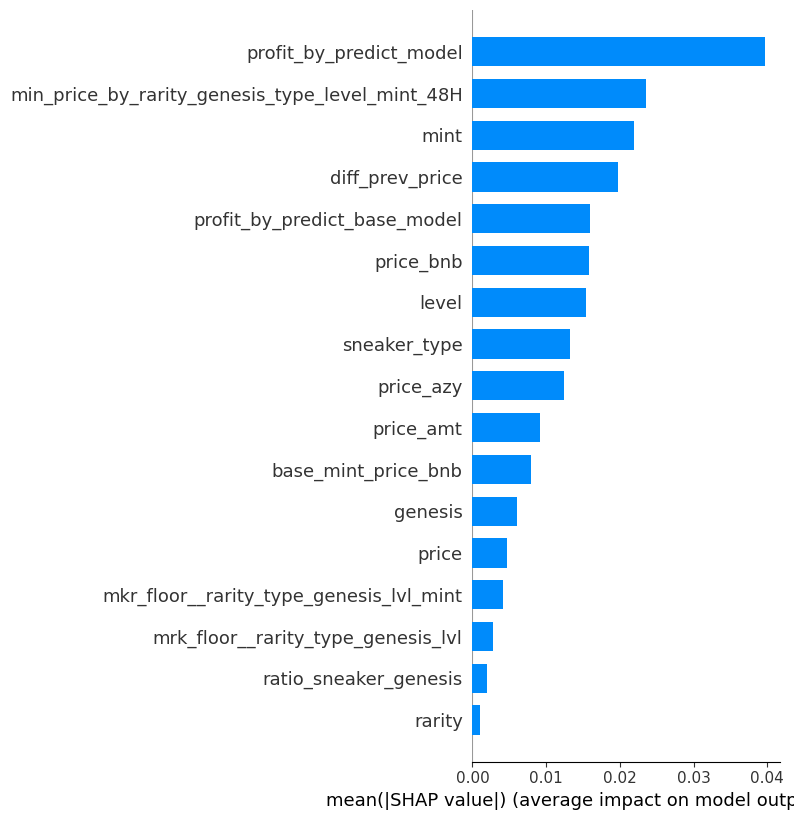

In [166]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(train_x)
shap.summary_plot(shap_values, features=X, feature_names=X.columns, plot_type='bar')

## TEST

In [167]:
model = CatBoostRegressor(
    depth=3,
    #learning_rate=0.01,
    #iterations=1000,
    loss_function='MAPE',
    random_seed=42
    )

# Fit model 
model.fit(X_train, y_train, cat_features=cat_features,)
#model.save_model(f'./models/sneaker_model_{VERSION}.model')

0:	learn: 0.1327005	total: 608us	remaining: 607ms
1:	learn: 0.1317016	total: 1.19ms	remaining: 594ms
2:	learn: 0.1311203	total: 1.67ms	remaining: 554ms
3:	learn: 0.1303022	total: 2.1ms	remaining: 523ms
4:	learn: 0.1293363	total: 2.53ms	remaining: 504ms
5:	learn: 0.1288768	total: 2.96ms	remaining: 490ms
6:	learn: 0.1285122	total: 3.36ms	remaining: 477ms
7:	learn: 0.1281328	total: 3.72ms	remaining: 462ms
8:	learn: 0.1271576	total: 4.14ms	remaining: 456ms
9:	learn: 0.1266967	total: 4.55ms	remaining: 451ms
10:	learn: 0.1257634	total: 4.97ms	remaining: 447ms
11:	learn: 0.1253844	total: 5.39ms	remaining: 444ms
12:	learn: 0.1250117	total: 5.8ms	remaining: 441ms
13:	learn: 0.1242370	total: 6.25ms	remaining: 441ms
14:	learn: 0.1236607	total: 6.69ms	remaining: 439ms
15:	learn: 0.1232452	total: 7.11ms	remaining: 437ms
16:	learn: 0.1229585	total: 7.51ms	remaining: 434ms
17:	learn: 0.1222921	total: 7.83ms	remaining: 427ms
18:	learn: 0.1215804	total: 8.14ms	remaining: 421ms
19:	learn: 0.1209595	tota

In [168]:
pred = model.predict(X_test)
pred = np.round(pred, 3)

score = score_regression_simple(y_test, pred,)
score

{'R2': 0.251, 'MAE': 0.144, 'MSE': 0.048, 'RMSE': 0.22, 'MAPE': 3.868}

In [169]:
submission = pd.DataFrame()
submission['profit'] = test_data.profit.copy().reset_index(drop=True)
submission['pred'] = pred

In [170]:
submission.profit.sum()

14.6037

In [171]:
submission

,profit,pred
0,0.0215,0.137
1,0.1700,0.313
2,0.3200,0.195
3,0.4500,0.261
4,0.1015,0.127
...,...,...
110,0.0565,0.230
111,0.0375,0.156
112,0.0280,0.166
113,0.0280,0.243


In [172]:
submission[submission['pred'] > 0.05].profit.sum()

14.476199999999999

In [173]:
pred = model.predict(X_test)
pred = np.round(pred, 2)

score = score_regression_simple(y_test, pred,)
score

iteritems is deprecated and will be removed in a future version. Use .items instead.


{'R2': 0.249, 'MAE': 0.144, 'MSE': 0.049, 'RMSE': 0.22, 'MAPE': 3.884}

## Fit full Model

In [174]:
X = data[features].copy().reset_index(drop=True)
y = data.target.copy().reset_index(drop=True)

model = CatBoostRegressor(
    depth=3,
    #learning_rate=0.01,
    #iterations=1000,
    loss_function='MAPE',
    random_seed=42
    )

# Fit model 
model.fit(X, y, cat_features=cat_features,)
model.save_model(f'./models/sneaker_profit_model_{VERSION}.model')

iteritems is deprecated and will be removed in a future version. Use .items instead.


0:	learn: 0.1300978	total: 839us	remaining: 839ms
1:	learn: 0.1296425	total: 1.56ms	remaining: 779ms
2:	learn: 0.1290032	total: 2.17ms	remaining: 722ms
3:	learn: 0.1284995	total: 2.8ms	remaining: 696ms
4:	learn: 0.1279111	total: 3.41ms	remaining: 679ms
5:	learn: 0.1274825	total: 3.99ms	remaining: 661ms
6:	learn: 0.1268103	total: 4.58ms	remaining: 650ms
7:	learn: 0.1259004	total: 5.16ms	remaining: 639ms
8:	learn: 0.1254394	total: 5.76ms	remaining: 635ms
9:	learn: 0.1248292	total: 6.32ms	remaining: 626ms
10:	learn: 0.1243664	total: 6.9ms	remaining: 620ms
11:	learn: 0.1239044	total: 7.42ms	remaining: 611ms
12:	learn: 0.1236811	total: 7.78ms	remaining: 591ms
13:	learn: 0.1235460	total: 8.11ms	remaining: 571ms
14:	learn: 0.1230289	total: 8.44ms	remaining: 554ms
15:	learn: 0.1225443	total: 8.8ms	remaining: 542ms
16:	learn: 0.1221404	total: 9.16ms	remaining: 530ms
17:	learn: 0.1219167	total: 9.51ms	remaining: 519ms
18:	learn: 0.1215918	total: 9.87ms	remaining: 509ms
19:	learn: 0.1212857	total

In [175]:
y

0      0.0770
1      0.0455
2      0.1740
3      0.3305
4      0.0685
        ...  
365    0.0565
366    0.0375
367    0.0280
368    0.0280
369    0.0160
Name: target, Length: 370, dtype: float64

### Test

In [176]:
i=102

In [177]:
sneaker_dict = {}

features = data.columns

for feature in features:
    sneaker_dict[feature] = data.iloc[i][feature]

sneaker_dict['sum_activity_24H'] = sneaker_dict['buy_count_24H'] + sneaker_dict['sell_count_24H'] + sneaker_dict['cancel_count_24H']
sneaker_dict['sells_activity_24H'] = sneaker_dict['sell_count_24H'] / sneaker_dict['buy_count_24H']

sneaker_dict

{'timestamp': 1663018024,
 'mrk_id': 28403,
 'token_id': 31393,
 'event': 'buy',
 'wallet_from': '0x76c35b424d454f7574b9aad283621009e91093b9',
 'wallet_to': '0x3273af210822c44afd7254510e612e4dbb1040a7',
 'price': 0.88,
 'item_type': 'sneakers',
 'rarity': 'common',
 'sneaker_type': 'hiker',
 'level': 9,
 'base_performance': 9.8,
 'base_fortune': 3.0,
 'base_joy': 8.1,
 'base_durability': 7.0,
 'performance': 38.8,
 'fortune': 5.7,
 'joy': 15.3,
 'durability': 20.3,
 'mint': 3,
 'parent1': 15366.0,
 'parent2': 17030.0,
 'genesis': False,
 'parent1_sneaker_type': 'hiker',
 'parent2_sneaker_type': 'hiker',
 'price_bnb': 292.57969912,
 'price_azy': 0.08934575,
 'price_amt': 0.55538718,
 'wallet_from_buy_count': 1.0,
 'wallet_from_all_count': 5.0,
 'token_all_activity_3H': 1,
 'token_sell_activity_6H': 1,
 'buy_count_12H': 227,
 'buy_count_24H': 305,
 'buy_count_48H': 536.0,
 'sell_count_12H': 461.0,
 'sell_count_24H': 665,
 'sell_count_48H': 1236.0,
 'cancel_count_12H': 308.0,
 'cancel_cou

In [178]:
dq = data_quality_expected_range_dict['sneaker']['is_in']
for feature in dq.keys():
    if sneaker_dict[feature] is None:
        print(f'Nans in {feature}')

    if sneaker_dict[feature] not in dq[feature]:
        print(f'{feature} not in data_quality_expected_range_dict. get {sneaker_dict[feature]}')

dq = data_quality_expected_range_dict['sneaker']['min_max']
for feature in dq.keys():
    if sneaker_dict[feature] is None:
        print(f'Nans in {feature}')

    if sneaker_dict[feature] < dq[feature][0]:
        print(f'{feature} less then expected. get: {sneaker_dict[feature]} | expected: {dq[feature][0]}')

    if sneaker_dict[feature] > dq[feature][1]:
        print(f'{feature} more then expected. get: {sneaker_dict[feature]} | expected: {dq[feature][1]}')

In [179]:
pd.Series(sneaker_dict)[model.feature_names_]

rarity                                                 common
sneaker_type                                            hiker
genesis                                                 False
level                                                       9
mint                                                        3
min_price_by_rarity_genesis_type_level_mint_48H           0.7
price                                                    0.88
base_mint_price_bnb                                  0.630547
price_bnb                                          292.579699
price_azy                                            0.089346
price_amt                                            0.555387
diff_prev_price                                         -0.12
ratio_sneaker_genesis                                     NaN
mkr_floor__rarity_type_genesis_lvl_mint                   NaN
mrk_floor__rarity_type_genesis_lvl                        NaN
profit_by_predict_model                                 0.187
profit_b

In [180]:
MODEL_DIR = './models/'
MODEL_NAME = f'sneaker_profit_model_{VERSION}.model'

model = CatBoostRegressor()      # parameters not required.
model.load_model(MODEL_DIR+MODEL_NAME)

sample = pd.Series(sneaker_dict)
predict_price = model.predict(sample[model.feature_names_])
predict_price = np.round(predict_price, 3)
predict_price

0.087

In [181]:
data.iloc[i]['profit']

0.10799999999999998

iteritems is deprecated and will be removed in a future version. Use .items instead.


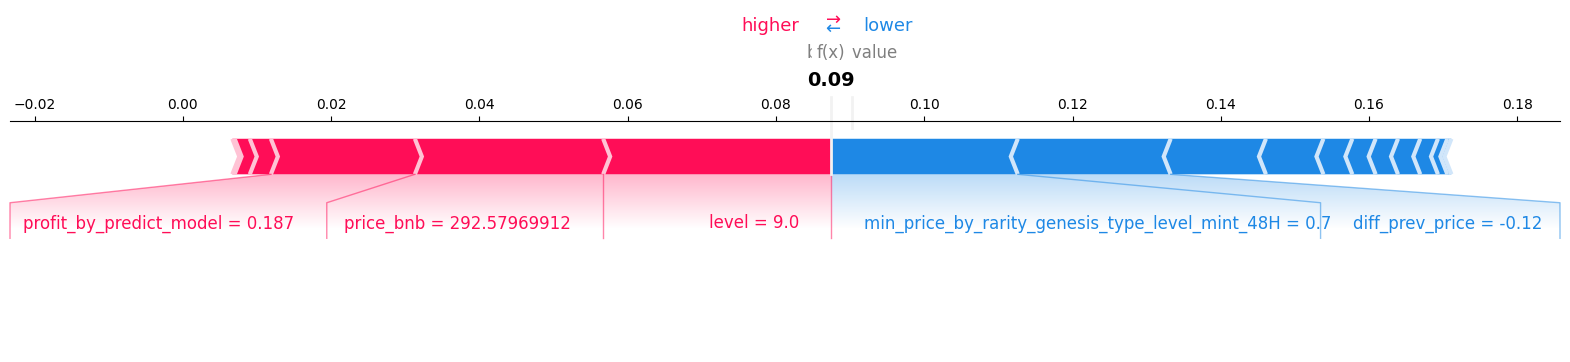

In [182]:
sample = pd.Series(sneaker_dict)
sample = pd.DataFrame(sample[model.feature_names_]).T
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(sample)
#shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], sample, show=True, matplotlib=True)